In [186]:
pwd

'c:\\Users\\User\\pub-CVAE-MRI-ASD\\Notebooks'

In [187]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

2025-06-07 11:30:10.978017


In [188]:
import tensorflow as tf
import numpy as np
import umap
import numba

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("UMAP:", umap.__version__)
print("Numba:", numba.__version__)


TensorFlow: 2.5.0
NumPy: 1.19.5
UMAP: 0.5.1
Numba: 0.54.1


In [189]:
%matplotlib inline

from importlib import reload
from helper_funcs import *
from make_models2 import *

# Make tqdm work for notebooks
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import pickle
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


print(now()-t00)

0:00:00.033002


In [190]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [191]:
import nibabel as nib

In [192]:
import glob

# Your folder path
folder_path = r'C:/Users/User/pub-CVAE-MRI-ASD/DARTEL_mwrc1'

# Automatically find all .nii or .nii.gz files
nii_files = glob.glob(os.path.join(folder_path, '*.nii')) + glob.glob(os.path.join(folder_path, '*.nii.gz'))

print(f"Found {len(nii_files)} files.")

# Optional: sort the files so the order is stable
nii_files.sort()

# Load each file
nii_data_list = []

for idx, file_path in enumerate(nii_files):
    img = nib.load(file_path)
    data = img.get_fdata()  # convert to numpy array
    nii_data_list.append(data)
    
    if idx % 50 == 0:
        print(f"Loaded {idx+1}/{len(nii_files)} files...")

# Stack into one big numpy array
nii_data_array = np.stack(nii_data_list, axis=0)  # shape will be (n_subjects, X, Y, Z)


Found 770 files.
Loaded 1/770 files...
Loaded 51/770 files...
Loaded 101/770 files...
Loaded 151/770 files...
Loaded 201/770 files...
Loaded 251/770 files...
Loaded 301/770 files...
Loaded 351/770 files...
Loaded 401/770 files...
Loaded 451/770 files...
Loaded 501/770 files...
Loaded 551/770 files...
Loaded 601/770 files...
Loaded 651/770 files...
Loaded 701/770 files...
Loaded 751/770 files...


In [193]:
# Prepare 'subs' array from filenames
subs = [os.path.basename(f) for f in nii_files]  # filenames only
subs = np.array(subs)

# Save as compressed npz
output_path = r'C:/Users/User/pub-CVAE-MRI-ASD/ADHD_data_combined.npz'
np.savez_compressed(output_path, data=nii_data_array, subs=subs)

print(f"Saved combined data to: {output_path}")
print(f"Combined shape: {nii_data_array.shape}")

Saved combined data to: C:/Users/User/pub-CVAE-MRI-ASD/ADHD_data_combined.npz
Combined shape: (770, 121, 145, 121)


In [194]:
# LOAD Data
arr = np.load(output_path)
ADHD_data = arr['data']
ADHD_data = np.nan_to_num(ADHD_data, nan=0.0)
ADHD_subs = arr['subs']
nsubs = ADHD_data.shape[0]
print([arr.shape for arr in [ADHD_subs,ADHD_data]])
print((ADHD_data.min(),ADHD_data.max()))
ADHD_subs_str = [s.decode() if isinstance(s, bytes) else s for s in ADHD_subs]


[(770,), (770, 121, 145, 121)]
(0.0, 6.613512992858887)


In [195]:
df = pd.read_csv('ADHD200_data_labels.csv')
VBM_df = pd.read_csv('VBM_subjects_matched.csv')


In [196]:
# Load Data Legend
df = pd.read_csv('C:/Users/User/pub-CVAE-MRI-ASD/Notebooks/VBM_subjects_matched.csv', header=0)
df = df.iloc[np.array([df['subs'].values[s] in ADHD_subs for s in range(len(df))])]
df.reset_index(inplace=True)
print(df.shape)

assert len(df)==len(ADHD_subs),'length mismatch'
assert all([df['subs'][s]==ADHD_subs[s] for s in range(len(df))]),'order mismatch'

df

(770, 23)


,index,Subject,subs,ScanDir ID,Site,Gender,Age,Handedness,DXbinary,DX,...,Inattentive,Hyper/Impulsive,IQ Measure,Verbal IQ,Performance IQ,Full2 IQ,Full4 IQ,Med Status,QC_Athena,QC_NIAK
0,0,10001,mwrc10010001.nii,10001,5,0.0,11.17,0.52,1,3,...,90.0,80.0,2.0,106.0,91.0,NaN,99.0,-999.0,1.0,1.0
1,1,10002,mwrc10010002.nii,10002,5,0.0,13.24,0.52,1,3,...,65.0,62.0,2.0,65.0,89.0,NaN,75.0,2.0,1.0,1.0
2,2,10003,mwrc10010003.nii,10003,5,0.0,9.29,0.11,0,0,...,42.0,43.0,2.0,107.0,93.0,NaN,100.0,1.0,1.0,0.0
3,3,10004,mwrc10010004.nii,10004,5,0.0,13.75,0.13,0,0,...,43.0,44.0,2.0,-999.0,-999.0,NaN,-999.0,1.0,1.0,1.0
4,4,10005,mwrc10010005.nii,10005,5,1.0,11.92,0.68,1,2,...,59.0,70.0,2.0,98.0,118.0,NaN,108.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,765,9887336,mwrc19887336.nii,9887336,1,1.0,11.33,1.00,0,0,...,13.0,11.0,3.0,128.0,135.0,NaN,135.0,1.0,1.0,1.0
766,766,9890726,mwrc19890726.nii,9890726,1,0.0,9.25,1.00,0,0,...,-999.0,-999.0,3.0,125.0,103.0,NaN,117.0,1.0,1.0,1.0
767,767,9907452,mwrc19907452.nii,9907452,5,1.0,9.98,0.74,1,3,...,64.0,46.0,2.0,130.0,127.0,NaN,132.0,1.0,1.0,1.0
768,768,9922944,mwrc19922944.nii,9922944,3,1.0,10.30,1.00,0,0,...,50.0,54.0,1.0,112.0,110.0,NaN,109.0,1.0,1.0,1.0


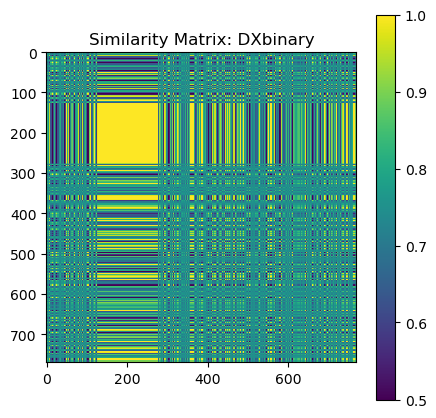

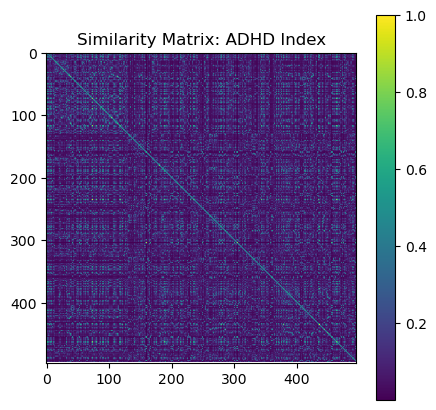

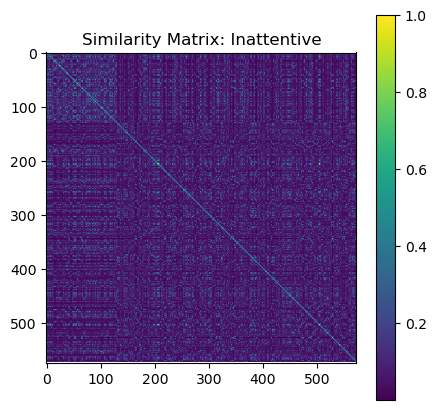

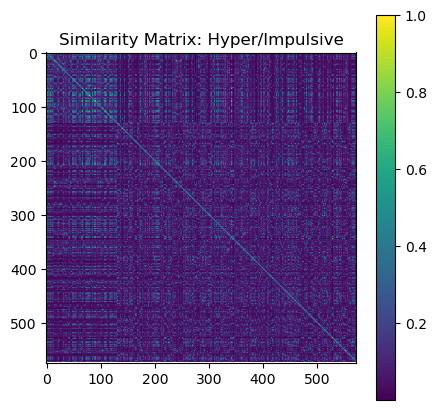

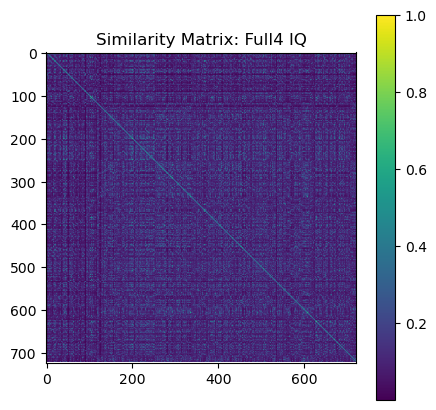

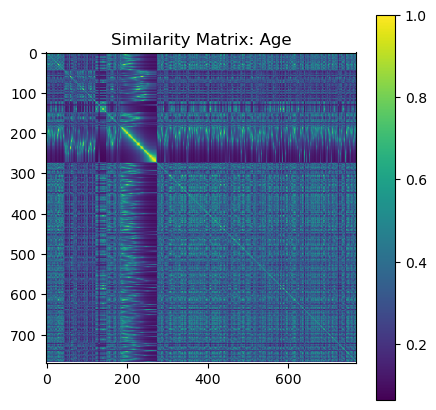

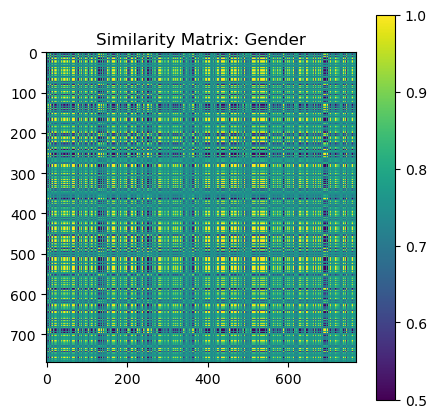

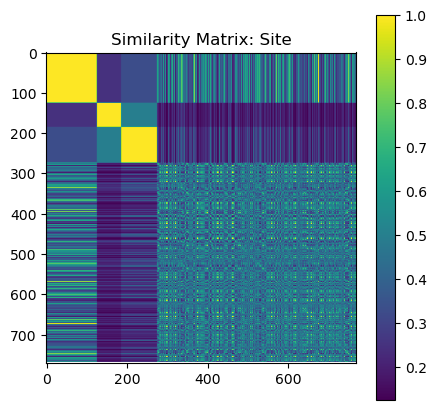

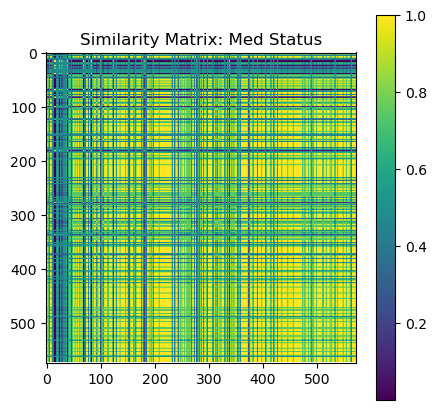

In [320]:
# Columns to use for similarity
cols = [
    'DXbinary',
    'ADHD Index',
    'Inattentive',
    'Hyper/Impulsive',
    'Full4 IQ',
    'Age',
    'Gender',
    'Site',
    'Med Status'
]

sim_mats = dict()

# Loop over columns
for col in cols:
    # Extract column
    values = df[col].apply(pd.to_numeric, errors='coerce').values
    
    # Drop NaN subjects
    idx_valid = ~np.isnan(values)
    values_valid = values[idx_valid]
    
    # Compute pairwise distance
    diff_mat = np.abs(values_valid[:, None] - values_valid[None, :])
    
    # Convert to similarity
    sim_mat = 1 / (1 + diff_mat)
    
    # Store
    sim_mats[col] = sim_mat
    
    # Plot
    plt.figure(figsize=(5,5))
    plt.imshow(sim_mat, cmap='viridis')
    plt.colorbar()
    plt.title(f'Similarity Matrix: {col}')
    plt.show()


In [199]:
import scipy.ndimage

# Target shape
target_shape = (64, 64, 64)

# Create empty array
ADHD_data_resampled = np.zeros((ADHD_data.shape[0], *target_shape))

# Loop and resample
for i in range(ADHD_data.shape[0]):
    zoom_factors = (
        target_shape[0] / ADHD_data.shape[1],
        target_shape[1] / ADHD_data.shape[2],
        target_shape[2] / ADHD_data.shape[3]
    )
    ADHD_data_resampled[i] = scipy.ndimage.zoom(ADHD_data[i], zoom_factors, order=3)  # cubic interpolation
    
    if i % 50 == 0:
        print(f"Resampled {i+1}/{ADHD_data.shape[0]}")

# Add channel dimension
ADHD_data_resampled = ADHD_data_resampled[..., np.newaxis]  # shape will be (770, 64, 64, 64, 1)

# Check shape
print(f"Resampled shape: {ADHD_data_resampled.shape}")


Resampled 1/770
Resampled 51/770
Resampled 101/770
Resampled 151/770
Resampled 201/770
Resampled 251/770
Resampled 301/770
Resampled 351/770
Resampled 401/770
Resampled 451/770
Resampled 501/770
Resampled 551/770
Resampled 601/770
Resampled 651/770
Resampled 701/770
Resampled 751/770
Resampled shape: (770, 64, 64, 64, 1)


In [201]:
# Split into control and ADHD
controls = df['DXbinary'] == 0
adhd = df['DXbinary'] == 1

TD_subs = ADHD_data_resampled[controls.values]
DX_subs = ADHD_data_resampled[adhd.values]

print("Control group shape:", TD_subs.shape)
print("ADHD group shape:", DX_subs.shape)


Control group shape: (487, 64, 64, 64, 1)
ADHD group shape: (283, 64, 64, 64, 1)


### TRAIN VAE

In [151]:
train_vae = True

In [179]:
if train_vae:
    
    latent_dim = 32
    batch_size = 16
    disentangle = False
    gamma = 100

    # Prepare input data: add channel dimension
    X = ADHD_data_resampled[..., np.newaxis]  # (n, 64, 64, 64, 1)

    # Model setup
    encoder, decoder, vae = get_MRI_VAE_3D(
        input_shape=(64, 64, 64, 1),
        latent_dim=latent_dim,
        batch_size=batch_size,
        disentangle=disentangle,
        gamma=gamma,
        kernel_size=3,
        filters=48,
        intermediate_dim=128,
        nlayers=2,
        bias=True
    )

    loss = []
    fn = 'outputs/VAE_weights'

    print(f"Saving model to: {fn}")

Saving model to: outputs/VAE_weights


In [180]:
encoder.summary(line_length=100)

Model: "encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       [(None, 64, 64, 64, 1 0                                            
____________________________________________________________________________________________________
conv3d_32 (Conv3D)               (None, 32, 32, 32, 96 2688        encoder_input[0][0]              
____________________________________________________________________________________________________
conv3d_33 (Conv3D)               (None, 16, 16, 16, 19 497856      conv3d_32[0][0]                  
____________________________________________________________________________________________________
flatten_22 (Flatten)             (None, 786432)        0           conv3d_33[0][0]                  
__________________________________________________________________________

In [181]:
decoder.summary(line_length=100)

Model: "decoder"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
z_sampling (InputLayer)                      [(None, 32)]                            0              
____________________________________________________________________________________________________
dense_43 (Dense)                             (None, 128)                             4224           
____________________________________________________________________________________________________
dense_44 (Dense)                             (None, 786432)                          101449728      
____________________________________________________________________________________________________
reshape_10 (Reshape)                         (None, 16, 16, 16, 192)                 0              
__________________________________________________________________________

In [182]:
nbatches = 101
if train_vae:
    for i in tqdm(range(1,nbatches)):    
        
        batch_idx = np.random.randint(low=0,high=ADHD_data_resampled.shape[0],size=batch_size)
        data_batch = ADHD_data_resampled[batch_idx,:,:,:]
        
        history = vae.train_on_batch(data_batch);
        mse = ((data_batch-vae.predict(data_batch))**2).mean()
        loss.append(history);

        if np.mod(i,5)==0: # Plot training progress
            im1 = data_batch[0,32,:,:];
            im = vae.predict(data_batch)[0,32,:,:,0];
            plot_trainProgress(loss,im,im1);

        if np.mod(i,100)==0: # Save every 100 batches
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            vae.save_weights(fn)    
        

  1%|          | 1/100 [01:07<1:50:51, 67.18s/it]


KeyboardInterrupt: 

### TRAIN CVAE

In [211]:
train_cvae = True

In [212]:
if train_cvae:
    
    latent_dim = 16
    batch_size = 16
    beta = 1;gamma = 100
    disentangle = True
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
    loss = list()    
    
    fn = 'outputs/CVAE_weights'
    loss = []

In [213]:
z_encoder.summary(line_length=100)

Model: "z_encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
tg_inputs (InputLayer)           [(None, 64, 64, 64, 1 0                                            
____________________________________________________________________________________________________
conv3d_58 (Conv3D)               (None, 32, 32, 32, 64 1792        tg_inputs[0][0]                  
____________________________________________________________________________________________________
conv3d_59 (Conv3D)               (None, 16, 16, 16, 12 221312      conv3d_58[0][0]                  
____________________________________________________________________________________________________
flatten_41 (Flatten)             (None, 524288)        0           conv3d_59[0][0]                  
________________________________________________________________________

In [214]:
cvae_decoder.summary(line_length=100)

Model: "decoder"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
z_sampling (InputLayer)                      [(None, 32)]                            0              
____________________________________________________________________________________________________
dense_77 (Dense)                             (None, 128)                             4224           
____________________________________________________________________________________________________
dense_78 (Dense)                             (None, 524288)                          67633152       
____________________________________________________________________________________________________
reshape_17 (Reshape)                         (None, 16, 16, 16, 128)                 0              
__________________________________________________________________________

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

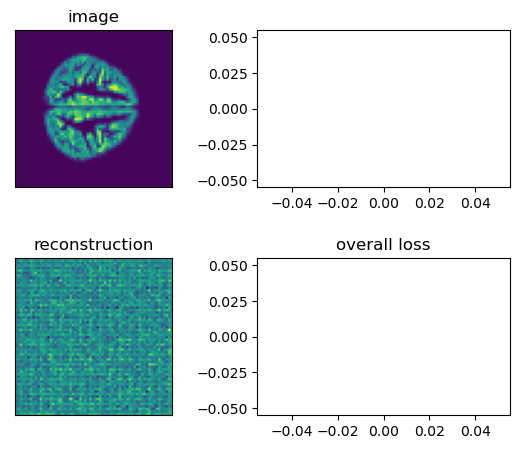

In [215]:
# initial check
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];

if len(loss)==0:
    loss.append(np.nan)
    im,im1,ss = cvae_query(ADHD_data_resampled,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);
    loss = list()
else:
    im,im1,ss = cvae_query(ADHD_data_resampled,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

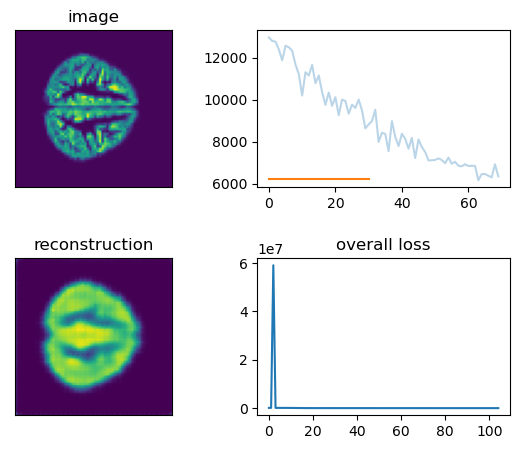

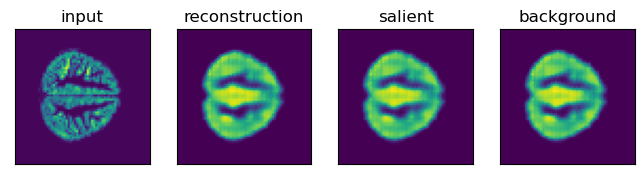

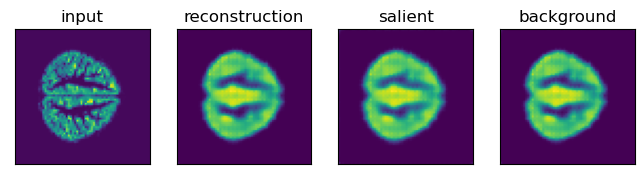

100%|██████████| 100/100 [30:49<00:00, 18.49s/it]


In [217]:
nbatches = 101
if train_cvae:
    for i in tqdm(range(1,nbatches)):
        
        DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
        TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
        
        hist = cvae.train_on_batch([DX_batch,TD_batch]);
        loss.append(hist);
        
        mse = ((np.array([DX_batch,TD_batch])-np.array(cvae.predict([DX_batch,TD_batch])))**2).mean()

        assert not np.isnan(hist),'loss is NaN - somethings wrong'

        im,im1,ss = cvae_query(ADHD_data_resampled, s_encoder, z_encoder, cvae_decoder); 

        

        if np.mod(i,5)==0: # Plot training progress
            plot_trainProgress(loss,im,im1);
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)

        if np.mod(i,100)==0: # Save every 100 batches
            cvae.save_weights(fn)

# 02 Extract Latent Features

In [265]:
%%time 
# LOAD CVAE
latent_dim = 16;batch_size = 16;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fn = 'outputs/CVAE_weights'
cvae.load_weights(fn)

ResourceExhaustedError: OOM when allocating tensor with shape[524288,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul]

In [266]:
n_samples = 10

salient_vec_adhd = np.array([s_encoder.predict(ADHD_data_resampled[:,:,:,:])[2] for _ in range(n_samples)])
background_vec_adhd = np.array([z_encoder.predict(ADHD_data_resampled[:,:,:,:])[2] for _ in range(n_samples)])
vae_vec_adhd = np.array([encoder.predict(ADHD_data_resampled[:,:,:,:])[2] for _ in range(n_samples)])

fn = 'latent_vecs10.npz'
np.savez_compressed(fn, 
                    salient_vec_adhd=salient_vec_adhd,
                    background_vec_adhd=background_vec_adhd,
                    vae_vec_adhd=vae_vec_adhd)

# 03 Analysis RSA

In [267]:
data_latent_vec = np.load('latent_vecs10.npz') # Load latent representations

In [268]:
list(data_latent_vec.keys())

['salient_vec_adhd', 'background_vec_adhd', 'vae_vec_adhd']

In [269]:
# Split dictionary into separate variables
salient_vec_adhd = data_latent_vec['salient_vec_adhd']
background_vec_adhd = data_latent_vec['background_vec_adhd']
vae_vec_adhd = data_latent_vec['vae_vec_adhd']

In [270]:
def data2cmat(data):
    return np.array([squareform(pdist(data[s,:,:],metric='euclidean')) for s in range(data.shape[0])])

In [306]:
# Bar plot function
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1
    


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = ['CVAE','BG','SL']
    plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(3)])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = ['CVAE','BG','SL']
        for i in range(c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = ['CVAE','BG','SL']

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

In [272]:
# Make (dis)similarity matrices
cmat_salient_vec_adhd = data2cmat(salient_vec_adhd)
cmat_background_vec_adhd = data2cmat(background_vec_adhd)
cmat_vae_vec_adhd = data2cmat(vae_vec_adhd)

In [329]:
# ABIDE MAKE MODELS 
plt.figure(figsize=(15,15))
default_keys = ['ADHD Index','Inattentive','Hyper/Impulsive','Full4 IQ','Age','Gender','Site','Med Status']
scales_ = ['ratio','ratio','ratio','ratio','ratio','ordinal','ordinal','ordinal']

model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    inVec = df[default_keys[i]].values[adhd];
    idx = ~np.isnan(inVec)
    inVec = inVec[idx];
    this_rdm = make_RDM(inVec,data_scale=scales_[i])
    
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

<Figure size 1500x1500 with 0 Axes>

In [324]:
def slice_cmat(data,idx):
    mat = data[adhd,:][:,adhd]
    mat = mat[idx,:][:,idx]
    return mat

In [325]:
def fit_rsa(data,key):
    corr = scipy.stats.stats.kendalltau
    r = np.array([corr(get_triu(slice_cmat(data[i,:,:],model_idxs[key])),get_triu(model_rdms[key]))[0] for i in range(10)])
    r = np.arctan(r)
    return r

In [326]:
data = [cmat_vae_vec_adhd,cmat_background_vec_adhd,cmat_salient_vec_adhd]

rsa_results = dict()
for key in default_keys:
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})

In [327]:
# # Define your PCA batteries
# keys_pca = {}
# keys_pca.update({'ADHD_PCA': ['ADHD Index', 'Inattentive', 'Hyper/Impulsive']})
# keys_pca.update({'IQ_PCA': ['Verbal IQ', 'Performance IQ']})

# # Run PCA RSA
# pca_keys = list(keys_pca.keys())
# model_pcas = dict()

# for key in pca_keys:
#     print(f"Running PCA RSA for {key}")
    
#     # Extract variables
#     arr = np.array(df.loc[adhd, keys_pca[key]].apply(pd.to_numeric, errors='coerce'))
    
#     # Valid subjects
#     idx = ~np.isnan(arr).any(axis=1)
#     mat = arr[idx, :]
    
#     # PCA
#     pca = PCA(n_components=1)
#     pca_vec = pca.fit_transform(mat)
    
#     # Make RDM
#     rdm = make_RDM(pca_vec)
    
#     # Save to model dicts
#     model_rdms.update({key: rdm})
#     model_idxs.update({key: idx})
#     model_pcas.update({key: pca_vec})
    
#     # Run RSA
#     res = np.array([fit_rsa(datum, key) for datum in data])
#     rsa_results.update({key: res})
    
#     # Optional: put back PCA scores into df
#     df[key] = np.nan
#     adhd_idx = np.where(adhd)[0]
#     valid_idx = adhd_idx[idx]
#     for i_rel, i_abs in enumerate(valid_idx):
#         df.loc[i_abs, key] = model_pcas[key][i_rel]

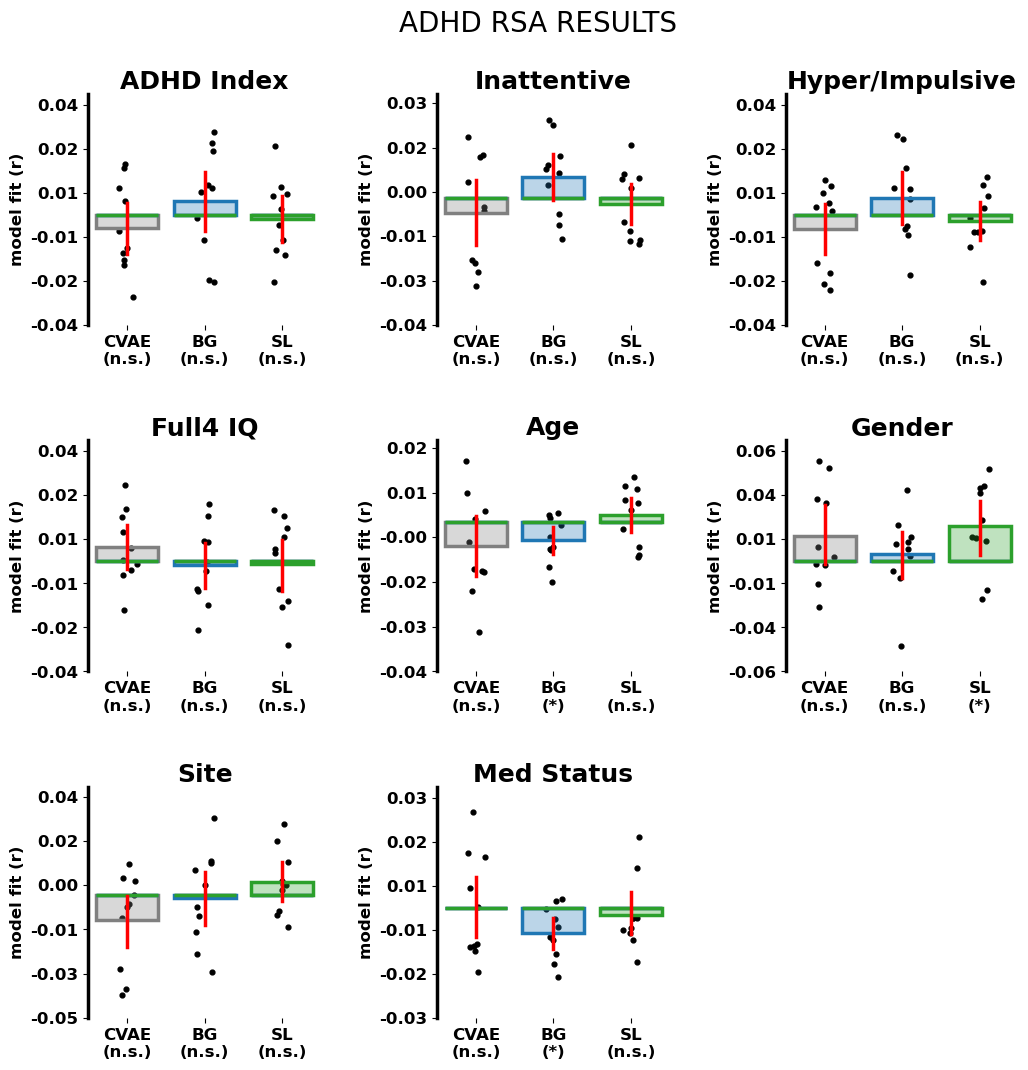

In [330]:
# PLOT ADHD RSAs

# Keys to plot
keys = [
    'ADHD Index',
    'Inattentive',
    'Hyper/Impulsive',
    'Full4 IQ',
    'Age',
    'Gender',
    'Site',
    'Med Status'
]

# Titles for plot
titles = [
    'ADHD Index',
    'Inattentive',
    'Hyper/Impulsive',
    'Full4 IQ',
    'Age',
    'Gender',
    'Site',
    'Med Status'
]

ncols = 3
nrows = int(np.ceil(len(keys)/3))

plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_results,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=titles[i])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('ADHD RSA RESULTS',fontsize=20,y=.95);

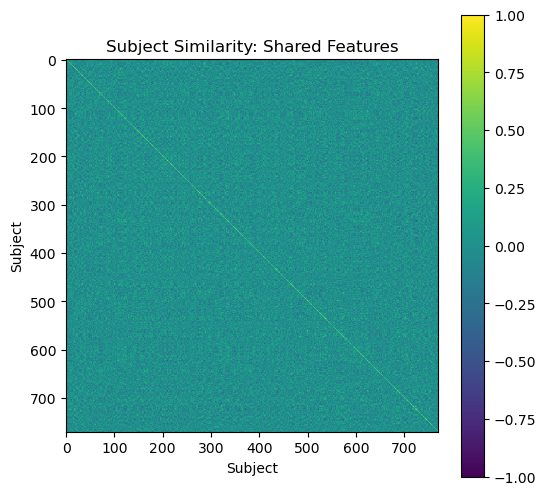

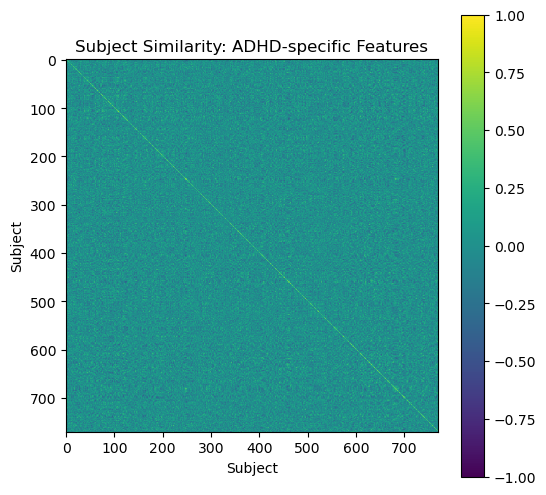

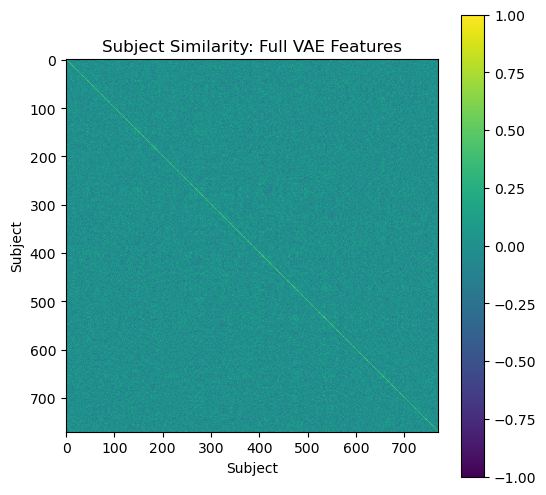

In [335]:
# Get latent vectors
latent_shared = z_encoder.predict(ADHD_data_resampled)[2]
latent_specific = s_encoder.predict(ADHD_data_resampled)[2]
latent_vae = encoder.predict(ADHD_data_resampled)[2]

# Build similarity matrices
cmat_shared = np.corrcoef(latent_shared)
cmat_specific = np.corrcoef(latent_specific)
cmat_vae = np.corrcoef(latent_vae)

mats = [cmat_shared, cmat_specific, cmat_vae]
titles = ['Subject Similarity: Shared Features',
          'Subject Similarity: ADHD-specific Features',
          'Subject Similarity: Full VAE Features']

# Loop and plot
for mat, title in zip(mats, titles):
    plt.figure(figsize=(6,6))
    plt.imshow(mat, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Subject')
    plt.ylabel('Subject')
    plt.show()


In [ ]:
# ADHD-related scales
adhd_scales = ['ADHD Index', 'Inattentive', 'Hyper/Impulsive']

# IQ-related scales
iq_scales = ['Verbal IQ', 'Performance IQ', 'Full2 IQ', 'Full4 IQ']

In [ ]:
# ADHD PCA — ADHD subjects only
arr_adhd = np.array(df.loc[adhd, adhd_scales].apply(pd.to_numeric, errors='coerce'))

# Mask valid subjects — ADHD only
idx_adhd_pca = ~np.isnan(arr_adhd).any(axis=1)

# PCA
mat_adhd = arr_adhd[idx_adhd_pca, :]
pca_adhd = PCA(n_components=1)
adhd_pca_vec = pca_adhd.fit_transform(mat_adhd)

# RDM
rdm_adhd = make_RDM(adhd_pca_vec)

In [ ]:
# IQ PCA
arr_iq = np.array(df[iq_scales].apply(pd.to_numeric, errors='coerce'))
idx_iq = ~np.isnan(arr_iq).any(axis=1)  # exclude subjects with NaN
mat_iq = arr_iq[idx_iq, :]

# Perform PCA
pca_iq = PCA(n_components=1)
iq_pca_vec = pca_iq.fit_transform(mat_iq)

# Create RDM for RSA
rdm_iq = make_RDM(iq_pca_vec)
